# Stock Market Prediction

## Overview

Accurate prediction of stock market asset is a significant and challenging task due to complicated nature of the financial stock markets. Considering the increasing availability and affordability of powerful computational engines, deep learning methods of prediction have proved its efficiency in finance.

## Business Understanding

A time series regression model using NN or other advanced techniques is built to predict the stock market. Stock market prediction aims to determine the future movement of the stock value of a financial exchange. This project is helpful for Stock investors and investment banks to have a better understanding in developing economical Strategy and in making financial decisions.

### Import Packages

In [2]:
import twint

import nest_asyncio
nest_asyncio.apply()

import pandas as pd
# pd.set_option('display.max_rows', 500)
# pd.set_option('display.max_columns', 500)
# pd.set_option('display.width', 1000)
import numpy as np
import matplotlib.pyplot as plt
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
#nltk.download('vader_lexicon')

## Twint

In [ ]:
%%capture
# Configuring Twint to search for the subject in the first specified city
c = twint.Config()

# The amount of tweets to return sorted by most recent
c.Limit = 1

# Input parameters
c.Search = "$AAPL"

# Removing retweets
c.Filter_retweets = True

# No pictures or video
c.Media = False

# English only
c.Lang ='en'

# Excluding tweets with links
c.Links ='exclude'

# Making the results pandas friendly
c.Pandas = True

twint.run.Search(c)

# Assigning the DF
df = twint.storage.panda.Tweets_df

CRITICAL:root:twint.run:Twint:Feed:noDataExpecting value: line 1 column 1 (char 0)
sleeping for 1.0 secs
CRITICAL:root:twint.run:Twint:Feed:noDataExpecting value: line 1 column 1 (char 0)
sleeping for 8.0 secs
CRITICAL:root:twint.run:Twint:Feed:noDataExpecting value: line 1 column 1 (char 0)
sleeping for 27.0 secs
CRITICAL:root:twint.run:Twint:Feed:noDataExpecting value: line 1 column 1 (char 0)
sleeping for 64.0 secs
CRITICAL:root:twint.run:Twint:Feed:noDataExpecting value: line 1 column 1 (char 0)
sleeping for 125.0 secs


In [5]:
def sentiment_class(score):
    """
    Labels each tweet based on its sentiment score
    """
    if score > 0: score = "Positive"
    elif score < 0: score ='Negative'
    else: score = 'Neutral'
        
    return score

In [7]:
# Instantiating the sentiment analyzer
sid = SentimentIntensityAnalyzer()

# Grabbing the sentiment scores and assigning them to a new column
df['sentiment'] = [sid.polarity_scores(df.tweet.iloc[i])['compound'] for i in range(len(df))]

# Labeling the tweets in a new column
df['feel'] = df.sentiment.apply(sentiment_class)

Neutral     54
Positive    32
Negative    14
Name: feel, dtype: int64


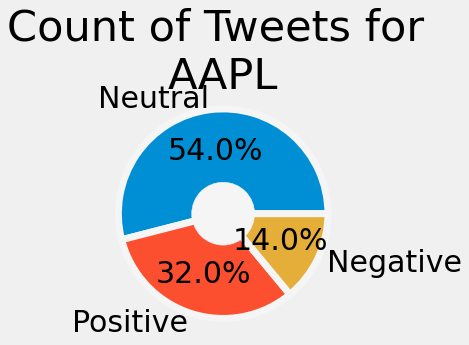

In [8]:
print(df.feel.value_counts())

plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 30
fig, ax = plt.subplots()

ax.pie(list(df.feel.value_counts()), 
       labels=df.feel.value_counts().index, 
       autopct='%1.1f%%',
       wedgeprops = { 'linewidth': 7, 'edgecolor': 'whitesmoke' })

circle = plt.Circle((0,0), 0.3, color='whitesmoke')
fig = plt.gcf()
fig.gca().add_artist(circle)

ax.set_title(f"Count of Tweets for \n{'AAPL'}")
ax.axis('equal')
plt.show()

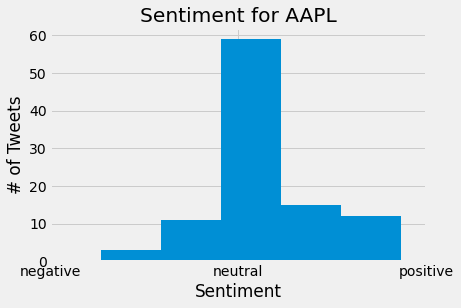

In [9]:
plt.style.use('fivethirtyeight')

fig, ax = plt.subplots()

# Plotting the sentiment scores
ax.hist(df['sentiment'], bins=5)

plt.title(f"Sentiment for {'AAPL'}")
ax.set_xticks([-1,0,1])
ax.set_xticklabels(['negative', 'neutral', 'positive'])
plt.xlabel("Sentiment")
plt.ylabel("# of Tweets")
plt.show()

### Analyze sentiment of tweets

In [14]:
from textblob import TextBlob
from IPython.display import Markdown, display

In [15]:
def printmd(string, color=None):
    colorstr = "<span style='color:{}'>{}</span>".format(color, string)
    display(Markdown(colorstr))

In [ ]:
for tweet in tweets:
    print(tweet)
    analysis = TextBlob(tweet)
    print(analysis.sentiment)
    if analysis.sentiment[0]>0:
        printmd('Positive', color="green")
    elif analysis.sentiment[0]<0:
        printmd('Negative', color="red")
    else:
        printmd("Neutral", color="grey")
        print("")

## Add sentiments to dataframe

In [24]:
from pyspark.sql.functions import udf

In [25]:
def apply_blob(sentence):
    temp = TextBlob(sentence).sentiment[0]
    if temp == 0.0:
        return 0.0 # Neutral
    elif temp >= 0.0:
        return 1.0 # Positive
    else:
        return 2.0 # Negative

In [26]:
sentiment = udf(apply_blob)

In [ ]:
clean_tweets.withColumn("sentiment", sentiment(clean_tweets['tweet'])).show()

## Setup everything

In [1]:
%load_ext autoreload
%autoreload 2

# Import twint
import sys
sys.path.append("twint/")

# Set up TWINT config
import twint
c = twint.Config()

# Other imports
import seaborn as sns
import os
from optimus import Optimus
op = Optimus()

# Solve compatibility issues with notebooks and RunTime errors.
import nest_asyncio
nest_asyncio.apply()

# Disable annoying printing

class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

/opt/conda/lib/python3.6/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.25.2) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


## The code with the magic

In [2]:
from textblob import TextBlob
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType

# Function to get sentiment 
def apply_blob(sentence):
    temp = TextBlob(sentence).sentiment[0]
    if temp == 0.0:
        return 0.0 # Neutral
    elif temp >= 0.0:
        return 1.0 # Positive
    else:
        return 2.0 # Negative

# UDF to write sentiment on DF
sentiment = udf(apply_blob, DoubleType())

# Transform result to pandas
def twint_to_pandas(columns):
    return twint.output.panda.Tweets_df[columns]

def tweets_sentiment(search, limit=1):
    c.Search = search
    # Custom output format
    c.Format = "Username: {username} |  Tweet: {tweet}"
    c.Limit = limit
    c.Pandas = True
    with HiddenPrints():
        print(twint.run.Search(c))
    
    # Transform tweets to pandas DF
    df_pd = twint_to_pandas(["date", "username", "tweet", "hashtags", "nlikes"])
    
    # Transform Pandas DF to Optimus/Spark DF
    df = op.create.data_frame(pdf= df_pd)
    
    # Clean tweets
    clean_tweets = df.cols.remove_accents("tweet") \
                 .cols.remove_special_chars("tweet")
    
    # Add sentiment to final DF
    return clean_tweets.withColumn("sentiment", sentiment(clean_tweets['tweet']))

In [3]:
df_result = tweets_sentiment("data science", limit=1)

In [ ]:
df_result.show()

### Lets see the distribution of the sentiments

In [37]:
df_res_pandas = df_result.toPandas()

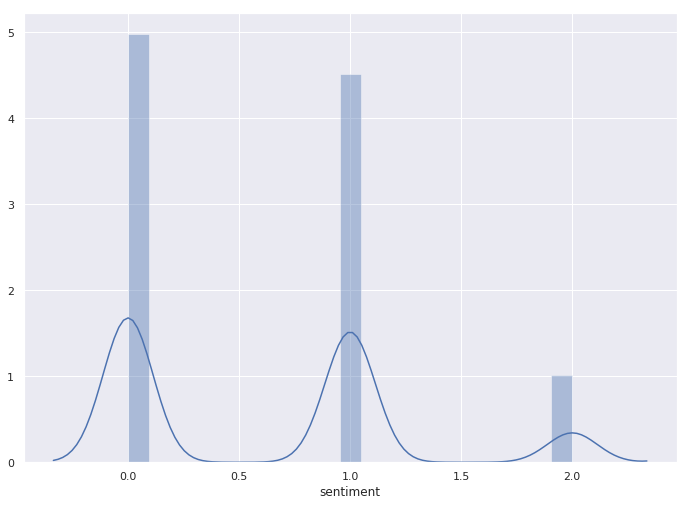

In [46]:
sns.distplot(df_res_pandas['sentiment'])
sns.set(rc={'figure.figsize':(11.7,8.27)})

# Lets do more with Twint

In [30]:
%load_ext autoreload
%autoreload 2

import sys, os
sys.path.append("twint/")

import twint
import numpy as np
from PIL import Image
from os import path

# Solve compatibility issues with notebooks and RunTime errors.
import nest_asyncio
nest_asyncio.apply()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
# Disable annoying printing

class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

## Get tweets easily

In [3]:
def get_tweets(search, limit=100):
    c = twint.Config()
    c.Search = search
    c.Limit = limit
    c.Pandas = True
    c.Pandas_clean = True

    with HiddenPrints():
        print(twint.run.Search(c))
    return twint.output.panda.Tweets_df[["username","tweet"]]

In [4]:
tweets = get_tweets("AAPL", limit=1000)

In [5]:
tweets.count()

username    10003
tweet       10003
dtype: int64

## Generate word cloud

In [6]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
%matplotlib inline

text = tweets.tweet.values

# adding movie script specific stopwords
stopwords = set(STOPWORDS)
stopwords.add("https")
stopwords.add("xa0")
stopwords.add("xa0'")
stopwords.add("bitly")
stopwords.add("bit")
stopwords.add("ly")
stopwords.add("twitter")
stopwords.add("pic")

wordcloud = WordCloud(
    background_color = 'black',
    width = 1000,
    height = 500,
    stopwords = stopwords).generate(str(text))

In [ ]:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.rcParams['figure.figsize'] = [10, 10]

In [12]:
def generate_word_cloud(tweets):
    
    # Getting the text out of the tweets
    text = tweets.tweet.values
    
    # adding movie script specific stopwords
    stopwords = set(STOPWORDS)
    stopwords.add("https")
    stopwords.add("xa0")
    stopwords.add("xa0'")
    stopwords.add("bitly")
    stopwords.add("bit")
    stopwords.add("ly")
    stopwords.add("twitter")
    stopwords.add("pic")

    wordcloud = WordCloud(
        background_color = 'black',
        width = 1000,
        height = 500,
        stopwords = stopwords).generate(str(text))
    
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.rcParams['figure.figsize'] = [10, 10]

## Other example

In [14]:
tweets = get_tweets("Apple", limit=1000)

In [ ]:
generate_word_cloud(tweets)

## Scaling up

In [ ]:
df_result = tweets_sentiment("AAPL", limit=10000)
df_result.show()